In [1]:
from data import LeaveOneOutDS
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, TQDMProgressBar
from ncf_pipeline import create_datasplitter, run_model


In [123]:
import pandas as pd
import numpy as np 


DATA_DIR = '/content/gdrive/MyDrive/data' 
DATA_DIR = '../data'
STUDY_DIR = DATA_DIR + '/study'

users = pd.read_csv(f'{DATA_DIR}/users.csv.gz')
topics = pd.read_csv(f'{DATA_DIR}/topics_translated.csv')
documents = pd.read_csv(f'{DATA_DIR}/documents.csv.gz')

# use study for less data, for testing
events = pd.read_csv(f'{DATA_DIR}/events.csv.gz')
transactions = pd.read_csv(f'{DATA_DIR}/transactions.csv.gz')

topic_trees = pd.read_csv(f'{DATA_DIR}/topic_trees.csv.gz')

In [3]:
from data import preprocess_events

events_preprocessed = preprocess_events(events, topics)
events_preprocessed_only_math = events_preprocessed[events_preprocessed['is_math'] == 1]
events_preprocessed_only_german = events_preprocessed[events_preprocessed['is_math'] == 0]

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

math_topics = set(topics[topics['math']==1]['id'])
german_topics = set(topics[topics['math']==0]['id'])

topic_trees = topic_trees[~topic_trees['parent_id'].isna()]

german_row = {'topic_id':0, 'parent_id':0, 'child_id':1, 'sibling_rank':0, 'displayed_on_dashboard': 0}
math_row = {'topic_id':1, 'parent_id':0, 'child_id':109, 'sibling_rank':0, 'displayed_on_dashboard': 0}

topic_trees = topic_trees.append(math_row, ignore_index=True)
topic_trees = topic_trees.append(german_row, ignore_index=True)

math_topic_tree = topic_trees[(topic_trees['parent_id'].isin(math_topics)) | (topic_trees['child_id'].isin(math_topics))]
german_topic_tree = topic_trees[(topic_trees['parent_id'].isin(german_topics)) | (topic_trees['child_id'].isin(german_topics))]


# def draw_topic_tree(topic_tree, title, node_color, figsize):
#   G = nx.from_pandas_edgelist(topic_tree, source='child_id', target='parent_id', edge_attr=['topic_id'])
#   plt.figure(figsize=figsize)
#   options = {"edge_color": "tab:gray", "node_color": node_color, "node_size": 100, "alpha": 0.8, "font_size": 7}
#   nx.draw_networkx(G, pos=nx.spring_layout(G), **options)
#   plt.title(title)
#   plt.show()

# draw_topic_tree(german_topic_tree, "Math topic tree", 'tab:red', (13, 12))


G = nx.from_pandas_edgelist(topic_trees, source='child_id', target='parent_id', edge_attr=['topic_id'])

PATHS = dict(nx.all_pairs_shortest_path_length(G, 20))

/tmp/ipykernel_7934/1305080819.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_trees = topic_trees.append(math_row, ignore_index=True)
/tmp/ipykernel_7934/1305080819.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_trees = topic_trees.append(german_row, ignore_index=True)


# Train the math model

In [4]:
math_ids = []
german_ids = []

# create data
math = True 
german = False 
features = True
data_math_withFeatures = create_datasplitter(math, german, features, users, topics, documents, events, transactions)
math_ids = data_math_withFeatures.get_topic_ids()






tables loaded.


/home/david/ETH/recommender/data.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.apply(get_val, axis=1)


Sampled initial validation and test interactions
Completed test dataset
Completed validation dataset
Completed train dataset
Adding features...


In [5]:
# train model
predictive_factors = 64
student_embed_dim = 512
topic_embed_dim = 128
joint = math and german 
out, model = run_model(features, predictive_factors, student_embed_dim, topic_embed_dim, data_math_withFeatures, joint, math_ids=math_ids)






/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


intermediate layer size (concatenated): 325


/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type       | Params
-------------------------------------------------------
0 | student_embedding_layer | Embedding  | 3.1 M 
1 | topic_embedding_layer   | Embedding  | 5.6 K 
2 | user_embed_MLP          | Sequential | 278 K 
3 | user_feature_MLP        | Sequential | 82    
4 | topic_embed_MLP         | Sequential | 17.6 K
5 | topic_feature_MLP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]HitRate@10 0.25
NDCG@10 0.10766913951834826
MRR@10 0.0625
                                                                           

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 1092/1092 [00:07<00:00, 144.87it/s, v_num=43, train_loss_step=0.292]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.5418933623503809
NDCG@10 0.30856084570016823
MRR@10 0.2381638945023058
Epoch 0: 100%|██████████| 1092/1092 [00:11<00:00, 95.41it/s, v_num=43, train_loss_step=0.292, val_loss=0.350, train_loss_epoch=0.491]

Metric val_loss improved. New best score: 0.350


Epoch 1: 100%|██████████| 1092/1092 [00:07<00:00, 144.11it/s, v_num=43, train_loss_step=0.403, val_loss=0.350, train_loss_epoch=0.491]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.5680087051142546
NDCG@10 0.32887837101978845
MRR@10 0.25613287389674766
Epoch 1: 100%|██████████| 1092/1092 [00:11<00:00, 95.48it/s, v_num=43, train_loss_step=0.403, val_loss=0.280, train_loss_epoch=0.435] 

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.280


Epoch 2: 100%|██████████| 1092/1092 [00:07<00:00, 144.04it/s, v_num=43, train_loss_step=0.586, val_loss=0.280, train_loss_epoch=0.435]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.5952121871599565
NDCG@10 0.3393228675369334
MRR@10 0.26207445981657085
Epoch 3: 100%|██████████| 1092/1092 [00:07<00:00, 142.36it/s, v_num=43, train_loss_step=0.297, val_loss=0.293, train_loss_epoch=0.391]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.6126224156692056
NDCG@10 0.33473756439344304
MRR@10 0.25203853394821835
Epoch 4: 100%|██████████| 1092/1092 [00:07<00:00, 141.73it/s, v_num=43, train_loss_step=0.407, val_loss=0.346, train_loss_epoch=0.360]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.6060935799782372
NDCG@10 0.3475351392147561
MRR@10 0.2698512012712231
Epoch 4: 100%|██████████| 1092/1092 [00:11<00:00, 93.83it/s, v_num=43, train_loss_step=0.407, val_loss=0.300, train_loss_epoch=0.336] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.280. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 1092/1092 [00:11<00:00, 93.34it/s, v_num=43, train_loss_step=0.407, val_loss=0.300, train_loss_epoch=0.336]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 3275/3275 [00:21<00:00, 153.70it/s]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


Testing DataLoader 0: 100%|██████████| 3275/3275 [00:22<00:00, 144.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       HitRate@10           0.5929407251103012
         MRR@10             0.25986125954953887
         NDCG@10            0.3372084454028295
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [6]:

male_id = users[users['gender']=='MALE'].iloc[0]['user_id']
female_id = users[users['gender']=='FEMALE'].iloc[0]['user_id']
other_id = users[users['gender'].isna()].iloc[0]['user_id']

uf = data_math_withFeatures.user_features
male_val = uf.loc[male_id]['gender']
female_val = uf.loc[female_id]['gender']
other_val = uf.loc[other_id]['gender']

In [7]:
from data import LeaveOneOutDS
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, TQDMProgressBar


trainer = pl.Trainer(
            accelerator="auto",
            devices=1,
            accumulate_grad_batches=1,
            max_epochs=1,
    )

test_data = data_math_withFeatures.get_test_data()

# female
for x in test_data:
    x[2][0] = female_val

dataset = LeaveOneOutDS(test_data, data_math_withFeatures.get_user_ids(), data_math_withFeatures.get_topic_ids())
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
trainer.test(model=model, dataloaders=dataloader)

female_out = model.eval_results


# male
for x in test_data:
    x[2][0] = male_val

dataset = LeaveOneOutDS(test_data, data_math_withFeatures.get_user_ids(), data_math_withFeatures.get_topic_ids())
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
trainer.test(model=model, dataloaders=dataloader)

male_out = model.eval_results

# ...


# other
for x in test_data:
    x[2][0] = other_val

dataset = LeaveOneOutDS(test_data, data_math_withFeatures.get_user_ids(), data_math_withFeatures.get_topic_ids())
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
trainer.test(model=model, dataloaders=dataloader)

other_out = model.eval_results

# ...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 3275/3275 [00:23<00:00, 140.35it/s]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


Testing DataLoader 0: 100%|██████████| 3275/3275 [00:24<00:00, 133.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       HitRate@10           0.5933243813543065
         MRR@10             0.2606004829196849
         NDCG@10            0.33783892955247663
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 3275/3275 [00:23<00:00, 140.10it/s]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


Testing DataLoader 0: 100%|██████████| 3275/3275 [00:24<00:00, 132.80it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       HitRate@10           0.5919815845002877
         MRR@10             0.2600185281606728
         NDCG@10             0.337097468500949
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 3275/3275 [00:23<00:00, 137.14it/s]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


Testing DataLoader 0: 100%|██████████| 3275/3275 [00:25<00:00, 130.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       HitRate@10           0.5910224438902744
         MRR@10             0.2592754225547243
         NDCG@10            0.3363142252881175
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [8]:
out_users = out[0]
out_topics = out[1]


usrids = data_math_withFeatures.get_user_ids()
topicids = data_math_withFeatures.get_topic_ids()

out_users = list(map(lambda x: usrids[int(x)], out_users))
out_topics = list(map(lambda x: topicids[int(x)], out_topics))


In [9]:
results = dict()
# get top 5 predictions on test set, remap user and topic id for each pediction, store together
n = 5

male_df = pd.DataFrame({'user_id': out_users, 'topic_id': out_topics, 'predict_proba': male_out[3].flatten()})
female_df = pd.DataFrame({'user_id': out_users, 'topic_id': out_topics, 'predict_proba': female_out[3].flatten()})
other_df = pd.DataFrame({'user_id': out_users, 'topic_id': out_topics, 'predict_proba': other_out[3].flatten()})

user_predict = male_df.groupby(['user_id'])
for user, topic in user_predict:
    # Get the top N of highest probability and rank them 
    results[user] = dict()

    topN = [x for _, x in sorted(zip(topic['predict_proba'], topic['topic_id']), reverse=True)][:n]
    results[user]['Male'] = topN
 
user_predict = female_df.groupby(['user_id'])
for user, topic in user_predict:
    # Get the top N of highest probability and rank them 

    topN = [x for _, x in sorted(zip(topic['predict_proba'], topic['topic_id']), reverse=True)][:n]
    results[user]['Female'] = topN
 
        
user_predict = other_df.groupby(['user_id'])
for user, topic in user_predict:
    # Get the top N of highest probability and rank them 

    topN = [x for _, x in sorted(zip(topic['predict_proba'], topic['topic_id']), reverse=True)][:n]
    results[user]['Other'] = topN
 
        
        

/tmp/ipykernel_79752/3548605448.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:
/tmp/ipykernel_79752/3548605448.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:
/tmp/ipykernel_79752/3548605448.py:26: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


In [5]:


transactions = transactions[~transactions['topic_id'].isna()]
transactions = transactions[~transactions['user_id'].isna()]

transactions['transaction_id'] = transactions['transaction_id'].astype(int)
transactions['user_id'] = transactions['user_id'].astype(int)

def compute_percentage_correct(transactions_df):

    topics = pd.DataFrame({'topic_id': transactions_df['topic_id'].unique(), 'dummy': transactions['topic_id'].unique()})
    topics = topics.set_index('topic_id', drop=True)

    partial_per_topic = transactions_df[transactions_df['evaluation'] == 'PARTIAL'].groupby('topic_id').count()['transaction_id']
    correct_per_topic = transactions_df[transactions_df['evaluation'] == 'CORRECT'].groupby('topic_id').count()['transaction_id']
    wrong_per_topic = transactions_df[transactions_df['evaluation'] == 'WRONG'].groupby('topic_id').count()['transaction_id']

    ppu_keys = partial_per_topic.keys()
    cpu_keys = correct_per_topic.keys()
    wpu_keys = wrong_per_topic.keys()

    def correctness_score(row):
        tid = row.name
        
        n_wrong = 0 if tid not in wpu_keys else wrong_per_topic[tid]
        n_partial = 0 if tid not in ppu_keys else partial_per_topic[tid]
        n_correct = 0 if tid not in cpu_keys else correct_per_topic[tid]

        total = n_wrong + n_correct + n_partial

        score = 100 * (n_correct + 0.5 * n_partial)


        if total == 0:
            return 0
        
        score /= total
        
        return score

    return topics.apply(correctness_score, axis=1)

TOPIC_CORRECTNESS = compute_percentage_correct(transactions)


In [36]:
PATHS[0]

{0.0: 0,
 109: 1,
 1: 1,
 950: 2,
 969: 2,
 985: 2,
 1006: 2,
 1030: 2,
 1045: 2,
 1058: 2,
 3079: 2,
 4826: 2,
 4835: 2,
 4850: 2,
 4868: 2,
 4884: 2,
 4895: 2,
 4901: 2,
 4911: 2,
 4915: 2,
 4938: 2,
 4944: 2,
 2: 2,
 2022: 2,
 3104: 2,
 3105: 2,
 3106: 2,
 3107: 2,
 3108: 2,
 3109: 2,
 951: 3,
 952: 3,
 956: 3,
 957: 3,
 958: 3,
 962: 3,
 963: 3,
 964: 3,
 968: 3,
 970: 3,
 971: 3,
 972: 3,
 973: 3,
 974: 3,
 978: 3,
 984: 3,
 5229: 3,
 986: 3,
 987: 3,
 992: 3,
 997: 3,
 1001: 3,
 1002: 3,
 1003: 3,
 1005: 3,
 4096: 3,
 4097: 3,
 1007: 3,
 1010: 3,
 1018: 3,
 1024: 3,
 1029: 3,
 5232: 3,
 1031: 3,
 1035: 3,
 1036: 3,
 1040: 3,
 1041: 3,
 1046: 3,
 1051: 3,
 1059: 3,
 1060: 3,
 1061: 3,
 1062: 3,
 1063: 3,
 1067: 3,
 2854: 3,
 2855: 3,
 2882: 3,
 2884: 3,
 2913: 3,
 2308: 3,
 2316: 3,
 2317: 3,
 2318: 3,
 2320: 3,
 2941: 3,
 2322: 3,
 2286: 3,
 2533: 3,
 2574: 3,
 2281: 3,
 3045: 3,
 2427: 3,
 2325: 3,
 3421: 3,
 4243: 3,
 4827: 3,
 4832: 3,
 4836: 3,
 4840: 3,
 4844: 3,
 4845: 3,
 

In [6]:
###########################################################################
# NOTE: param 'topic' should be the topic_id as found in the topics table #
###########################################################################


def generality(topic, user, train_user_topics=None):
    """
    how general vs how detailed is the topic,
    distance in topic tree from root
    """

    # assert topic in PATHS[0].keys() and topic != 0, "topic not found, make sure the topic id is in the original topics table"

    return 1/PATHS[0][topic]

    

def difficulty(topic, user, train_user_topics=None):
    """
    difficulty of the topic,
    fraction of questions that were answered incorrectly 
    """
    
    if topic in TOPIC_CORRECTNESS.keys():
        return (100 - TOPIC_CORRECTNESS[topic])/100 

    return 0.5





def novelty(topic, user, train_user_topics=None):
    """
    novelty of the topic,
    1 = new, 0 = old
    """
    
    # assert topic in topics['id'].unique() and user in events['user_id'].unique(), "MESSAGE TODO:"
    if user in train_user_topics.keys():
        return int(topic not in train_user_topics[user])
    
    return 1

def novelty_gru(topic, sequence):
    return int(topic not in sequence)


In [12]:
# TODO: vary the 'gender' feature for all the datapoints in the test set and compare recommended topics

n = 5


L = 0


metrics = ['generality', 'difficulty', 'novelty']


func = {'generality': generality, 'difficulty': difficulty, 'novelty': novelty}

male = {'generality': 0, 'difficulty': 0, 'novelty': 0}
female = {'generality': 0, 'difficulty': 0, 'novelty': 0}
other = {'generality': 0, 'difficulty': 0, 'novelty': 0}


print("build train_user_topics")

train_user_topics = dict()
for x in data_math_withFeatures.get_data():
    if x[0] not in train_user_topics.keys():
        train_user_topics[x[0]] = set()
    
    train_user_topics[x[0]].add(x[1])

print("done")


for num, uid in enumerate(results.keys()):
    if num % 100 == 0:
        print(num)

    outputs = results[uid]

    for k in metrics:
        assert len(outputs['Male']) == len(outputs['Female'])
        assert len(outputs['Male']) == len(outputs['Other'])
        for i in range(len(outputs['Male'])):
            male[k] += func[k](outputs['Male'][i], uid, train_user_topics=train_user_topics)
            female[k] += func[k](outputs['Female'][i], uid, train_user_topics=train_user_topics)
            other[k] += func[k](outputs['Other'][i], uid, train_user_topics=train_user_topics)
            L += 1

L = L//3

build train_user_topics
done
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200


In [14]:


import matplotlib.pyplot as plt
import numpy as np

metrics_labels = ["Generality", "Difficulty", "Novelty"]
data = {
    'Female': [female[k] for k in metrics],
    'Male': [male[k] for k in metrics],
    'Other': [other[k] for k in metrics],
}

for k in data.keys():
    for i in range(3):
        data[k][i] /= L


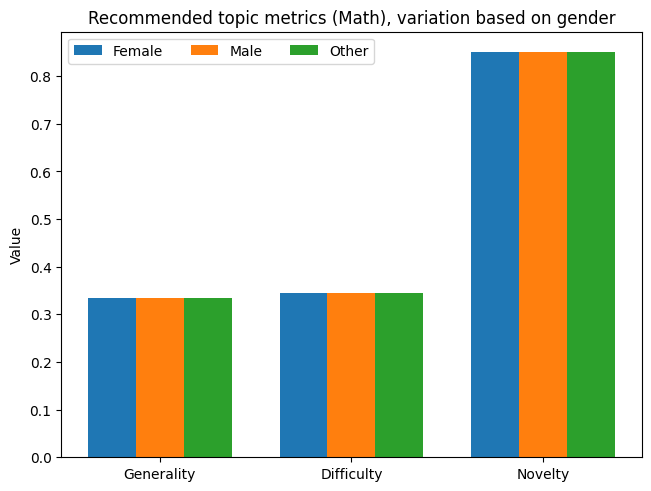

In [15]:

x = np.arange(len(metrics_labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Recommended topic metrics (Math), variation based on gender')
ax.set_xticks(x + width, metrics_labels)
ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 0.2)

plt.show()

# Same for german

In [ ]:

math_ids = []
german_ids = []

# create data
math = False 
german = True 
features = True
data_german_withFeatures = create_datasplitter(math, german, features, users, topics, documents, events, transactions)
german_ids = data_german_withFeatures.get_topic_ids()

joint = math and german 
out, model = run_model(features, predictive_factors, student_embed_dim, topic_embed_dim, data_german_withFeatures, joint, german_ids=german_ids)


male_id = users[users['gender']=='MALE'].iloc[0]['user_id']
female_id = users[users['gender']=='FEMALE'].iloc[0]['user_id']
other_id = users[users['gender'].isna()].iloc[0]['user_id']

uf = data_german_withFeatures.user_features
male_val = uf.loc[male_id]['gender']
female_val = uf.loc[female_id]['gender']
other_val = uf.loc[other_id]['gender']


trainer = pl.Trainer(
            accelerator="auto",
            devices=1,
            accumulate_grad_batches=1,
            max_epochs=1,
    )

test_data = data_german_withFeatures.get_test_data()

# female
for x in test_data:
    x[2][0] = female_val

dataset = LeaveOneOutDS(test_data, data_german_withFeatures.get_user_ids(), data_german_withFeatures.get_topic_ids())
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
trainer.test(model=model, dataloaders=dataloader)

female_out = model.eval_results


# male
for x in test_data:
    x[2][0] = male_val

dataset = LeaveOneOutDS(test_data, data_german_withFeatures.get_user_ids(), data_german_withFeatures.get_topic_ids())
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
trainer.test(model=model, dataloaders=dataloader)

male_out = model.eval_results

# ...


# other
for x in test_data:
    x[2][0] = other_val

dataset = LeaveOneOutDS(test_data, data_german_withFeatures.get_user_ids(), data_german_withFeatures.get_topic_ids())
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
trainer.test(model=model, dataloaders=dataloader)

other_out = model.eval_results



In [66]:
# female
for x in test_data:
    x[2][0] = female_val

dataset = LeaveOneOutDS(deepcopy(test_data), data_german_withFeatures.get_user_ids(), data_german_withFeatures.get_topic_ids())

fem = dataset

print(dataset.__getitem__(0))

# male
for x in test_data:
    x[2][0] = male_val

dataset = LeaveOneOutDS(deepcopy(test_data), data_german_withFeatures.get_user_ids(), data_german_withFeatures.get_topic_ids())
dataset.__getitem__(0)

print(dataset.__getitem__(0))
print(fem.__getitem__(0))


(tensor(8204), tensor(0), tensor([ 0.9008,  0.3003, -0.3901,  1.6745,  0.1483, -0.0899,  0.0074,  0.0683]), tensor([-0.2267,  5.3479]), tensor([0.]))
(tensor(8204), tensor(0), tensor([-0.4380,  0.3003, -0.3901,  1.6745,  0.1483, -0.0899,  0.0074,  0.0683]), tensor([-0.2267,  5.3479]), tensor([0.]))
(tensor(8204), tensor(0), tensor([ 0.9008,  0.3003, -0.3901,  1.6745,  0.1483, -0.0899,  0.0074,  0.0683]), tensor([-0.2267,  5.3479]), tensor([0.]))


In [60]:

# ...
out_users = out[0]
out_topics = out[1]


usrids = data_german_withFeatures.get_user_ids()
topicids = data_german_withFeatures.get_topic_ids()

out_users = list(map(lambda x: usrids[int(x)], out_users))
out_topics = list(map(lambda x: topicids[int(x)], out_topics))


results2 = dict()
# get top 5 predictions on test set, remap user and topic id for each pediction, store together
n = 5

male_df = pd.DataFrame({'user_id': out_users, 'topic_id': out_topics, 'predict_proba': male_out[3].flatten()})
female_df = pd.DataFrame({'user_id': out_users, 'topic_id': out_topics, 'predict_proba': female_out[3].flatten()})
other_df = pd.DataFrame({'user_id': out_users, 'topic_id': out_topics, 'predict_proba': other_out[3].flatten()})

user_predict = male_df.groupby(['user_id'])
for user, topic in user_predict:
    # Get the top N of highest probability and rank them 
    results2[user] = dict()

    topN = [x for _, x in sorted(zip(topic['predict_proba'], topic['topic_id']), reverse=True)][:n]
    results2[user]['Male'] = topN
 
user_predict = female_df.groupby(['user_id'])
for user, topic in user_predict:
    # Get the top N of highest probability and rank them 

    topN = [x for _, x in sorted(zip(topic['predict_proba'], topic['topic_id']), reverse=True)][:n]
    results2[user]['Female'] = topN
 
        
user_predict = other_df.groupby(['user_id'])
for user, topic in user_predict:
    # Get the top N of highest probability and rank them 

    topN = [x for _, x in sorted(zip(topic['predict_proba'], topic['topic_id']), reverse=True)][:n]
    results2[user]['Other'] = topN
 



/tmp/ipykernel_77208/1461969352.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:
/tmp/ipykernel_77208/1461969352.py:30: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:
/tmp/ipykernel_77208/1461969352.py:38: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


In [61]:

n = 5


L = 0


metrics = ['generality', 'difficulty', 'novelty']


func = {'generality': generality, 'difficulty': difficulty, 'novelty': novelty}

male_german = {'generality': 0, 'difficulty': 0, 'novelty': 0}
female_german = {'generality': 0, 'difficulty': 0, 'novelty': 0}
other_german = {'generality': 0, 'difficulty': 0, 'novelty': 0}

print("build train_user_topics")

train_user_topics = dict()
for x in data_german_withFeatures.get_data():
    if x[0] not in train_user_topics.keys():
        train_user_topics[x[0]] = set()
    
    train_user_topics[x[0]].add(x[1])

print("done")

for num, uid in enumerate(results2.keys()):
    if num % 100 == 0:
        print(num)

    outputs = results2[uid]

    for k in metrics:
        for i in range(len(outputs['Male'])):
            male_german[k] += func[k](outputs['Male'][i], uid, train_user_topics=train_user_topics)
            female_german[k] += func[k](outputs['Female'][i], uid, train_user_topics=train_user_topics)
            other_german[k] += func[k](outputs['Other'][i], uid, train_user_topics=train_user_topics)
            L += 1

L = L//3

import matplotlib.pyplot as plt
import numpy as np




build train_user_topics
done
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200


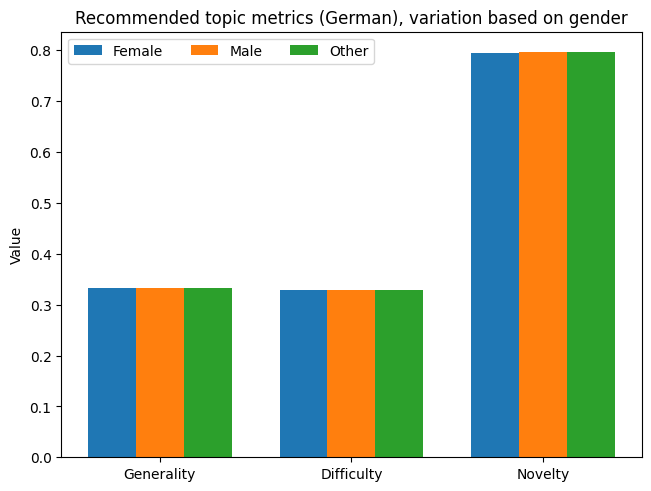

In [63]:

metrics_labels = ["Generality", "Difficulty", "Novelty"]
data_german = {
    'Female': [female_german[k] for k in metrics],
    'Male': [male_german[k] for k in metrics],
    'Other': [other_german[k] for k in metrics],
}

for k in data_german.keys():
    for i in range(3):
        data_german[k][i] /= L

x = np.arange(len(metrics_labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data_german.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Recommended topic metrics (German), variation based on gender')
ax.set_xticks(x + width, metrics_labels)
ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 0.2)

plt.show()

In [ ]:
# TODO: make note on novelty metric in report

In [ ]:
# TODO: check if with & without featuress ressults in the same set of user and topic ids  for test

In [7]:
from data import SequentialSplitter
from gru4rec_model import GRU4RecNetwork
from torch import optim, nn
from ncf_pipeline import create_datasplitter, run_model
from predictions import get_predictions, write_outputs


RESULTS_MATH = dict()
RESULTS_GERMAN = dict()
GRU_MATH = dict()
GRU_GERMAN = dict()

def collect_model_data_ncf(modelname, german, math, features, splitter):

    math_ids = []
    german_ids = []

    # create data
    data_ = splitter
    if german:
        german_ids = data_.get_topic_ids()
    elif math:
        math_ids = data_.get_topic_ids()

    predictive_factors = 64
    student_embed_dim = 512
    topic_embed_dim = 128
    joint = math and german  
    out, model = run_model(features, predictive_factors, student_embed_dim, topic_embed_dim, data_, joint, german_ids=german_ids, math_ids=math_ids)


    print("build train_user_topics")

    train_user_topics = dict()
    for x in data_.get_data():
        if x[0] not in train_user_topics.keys():
            train_user_topics[x[0]] = set()
        
        train_user_topics[x[0]].add(x[1])

    print("done")

    print("test user ids")

    test_user_ids = list(map(lambda x: x[0], data_.get_test_data()))
    test_user_ids = list(set(test_user_ids))

    print("done")

    # ...
    out_users = out[0]
    out_topics = out[1]


    usrids = data_.get_user_ids()
    topicids = data_.get_topic_ids()

    out_users = list(map(lambda x: usrids[int(x)], out_users))
    out_topics = list(map(lambda x: topicids[int(x)], out_topics))


    
    # get top 5 predictions on test set, remap user and topic id for each pediction, store together
    n = 5

    df = pd.DataFrame({'user_id': out_users, 'topic_id': out_topics, 'predict_proba': out[3].flatten()})

    user_predict = df.groupby(['user_id'])
    for user, topic in user_predict:
        # Get the top N of highest probability and rank them 
        topN = [x for _, x in sorted(zip(topic['predict_proba'], topic['topic_id']), reverse=True)][:n]


        if math:
            res = RESULTS_MATH
        else:
            res = RESULTS_GERMAN

        if user not in res.keys():
            res[user] = dict()

        res[user][modelname] = topN

    return train_user_topics, test_user_ids
    



In [116]:

def collect_model_data_gru(math, german):
    modelname = "GRU4Rec"

    data_splitter = None
    if math:
        data_splitter = SequentialSplitter(events_preprocessed_only_math)
    elif german:
        data_splitter = SequentialSplitter(events_preprocessed_only_german)

    BATCH_SIZE = 64
    train_dataloader = DataLoader(data_splitter.get_train_dataset(), batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(data_splitter.get_val_dataset(), batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(data_splitter.get_test_dataset(), batch_size=BATCH_SIZE, shuffle=False)



    TOPIC_EMBEDDING_DIM = 64
    HIDDEN_DIM = 256


    gru4rec = GRU4RecNetwork(
        num_topics=data_splitter.get_num_topics(),
        topic_embedding_dim=TOPIC_EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        dropout_rate=0.3,
        loss=nn.NLLLoss(),
    )


    EPOCHS = 15

    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=0.0,
        patience=2,
        verbose=True,
        mode="min"
    )

    trainer = pl.Trainer(
            accelerator="auto",
            devices=1,
            accumulate_grad_batches=1,
            max_epochs=EPOCHS,
            callbacks=[TQDMProgressBar(refresh_rate=10), early_stop_callback],
            val_check_interval=0.5
    )

    trainer.fit(model=gru4rec, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
    trainer.test(model=gru4rec, dataloaders=test_dataloader)

    # TODO: add results


    predictions = get_predictions(data_splitter.get_test_data(), gru4rec.predict_proba, is_sequential=True, topic_ids=data_splitter.get_topic_ids())
    

    df = pd.DataFrame(data=predictions, columns=["user_id", "topic_id", "-", "predict_proba"])

    user_predict = df.groupby(['user_id'])
    for user, topic in user_predict:
        # Get the top N of highest probability and rank them 
        topN = [x for _, x in sorted(zip(topic['predict_proba'], topic['topic_id']), reverse=True)][:5]


        if math:
            res = GRU_MATH
        else:
            res = GRU_GERMAN

        

        res[user] = topN

    return data_splitter


from transformer_model import TransformerRecommender

def compute_transformer_metrics(math, german):
    modelname = "Transformer"
    
    if math:
        data = events_preprocessed_only_math
    elif german:
        data = events_preprocessed_only_german

    recommender = TransformerRecommender(
        data,
        max_length=80,
        hidden_size=128,
        num_layers=2,
        num_heads=2,
        dropout=0.2
    )

    train_losses = recommender.train(
        batch_size=80,
        num_epochs=10,
        lr=0.001,
        window_size=2
    )

    test = recommender._split_sequences(recommender.sequences, 2)[1]
    l = len(test)
    test = {i: test[i] for i in range(len(test))}
    for i in range(l):
        recommender.sequences[i] = test[i]

    data = {'generality': 0, 'difficulty': 0, 'novelty': 0}

    count = 0

    for user in range(l):
        # Get the top N of highest probability and rank them 
        predictions = recommender.predict_topk_topics(user, 5)
        predictions = list(map(lambda x: x[0], predictions))

        for t in predictions:
            data['generality'] += generality(topic, user)
            data['difficulty'] += generality(topic, user)
            data['novelty'] += novelty_gru(recommender.topic_encoder[topic], test[user])
            count += 1


        
    
    print("count", count)
    print("l", l)
    
    for k in data.keys():
        data[k] /= count

        

    return data
    


# Math

In [9]:
splitter = create_datasplitter(True, False, True, users, topics, documents, events, transactions)


tables loaded.


/home/david/ETH/recommender/data.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.apply(get_val, axis=1)


Sampled initial validation and test interactions
Completed test dataset
Completed validation dataset
Completed train dataset
Adding features...


In [ ]:
math_feat_train_user_topics, math_feat_test_user_ids = collect_model_data_ncf("NCF with features", False, True, True, splitter)

In [ ]:
splitter.change_features(False, None, None)
math_nofeat_train_user_topics, math_nofeat_test_user_ids = collect_model_data_ncf("NCF", False, True, False, splitter)

In [ ]:
grusplit = collect_model_data_gru(True, False)

In [ ]:
# TODO: how to do transformer



In [37]:
RESULTS_MATH

{387604: {'NCF with features': [952, 956, 957, 962, 958],
  'NCF': [952, 958, 956, 972, 973],
  'Transformer': [958, 956, 964, 952, 972]},
 387608: {'NCF with features': [1060, 1010, 1007, 997, 1063],
  'NCF': [951, 952, 973, 972, 958],
  'Transformer': [997, 992, 1001, 973, 1036]},
 387650: {'NCF with features': [951, 1010, 1059, 1007, 1060],
  'NCF': [951, 962, 1010, 1059, 957],
  'Transformer': [1035, 970, 1003, 1046, 4096]},
 387667: {'NCF with features': [952, 970, 958, 956, 964],
  'NCF': [952, 957, 986, 956, 964],
  'Transformer': [1051, 968, 1024, 962, 1063]},
 387670: {'NCF with features': [1059, 1060, 958, 970, 1061],
  'NCF': [957, 986, 956, 964, 968],
  'Transformer': [1051, 968, 1024, 962, 970]},
 387671: {'NCF with features': [1010, 1007, 1059, 951, 987],
  'NCF': [987, 958, 972, 992, 951],
  'Transformer': [1018, 997, 963, 1007, 1001]},
 387672: {'NCF with features': [952, 970, 958, 956, 964],
  'NCF': [952, 957, 986, 956, 970],
  'Transformer': [962, 1051, 1031, 968, 10

In [ ]:
# TODO: for all models, compute those metrics for the predictions on the test set
# compare the models, prediction of novelty, difficulty, generality


n = 5
 
# TODO: replace this with the output from the different models
results_math = {
    0: {'NCF': [0,1,2,3,4], 'NCF with features': [4,5,6,7,8], 'Transformer': [5,6,7,8,9]},
    1: {'NCF': [0,1,2,3,4], 'NCF with features': [4,5,6,7,8], 'Transformer': [5,6,7,8,9]},
    2: {'NCF': [0,1,2,3,4], 'NCF with features': [4,5,6,7,8], 'Transformer': [5,6,7,8,9]},
}


results_math = RESULTS_MATH



gru_math = {
    0: [0,2,3,4],
    1: [4,5,6,7]
}


gru_math = GRU_MATH

L = 0
L_gru = 0


metrics = ['generality', 'difficulty', 'novelty']


func = {'generality': generality, 'difficulty': difficulty, 'novelty': novelty}

ncf = {'generality': 0, 'difficulty': 0, 'novelty': 0}
ncf_feature = {'generality': 0, 'difficulty': 0, 'novelty': 0}
gru4rec = {'generality': 0, 'difficulty': 0, 'novelty': 0}

transformer = compute_transformer_metrics(True, False)



for uid in results_math.keys():
    outputs = results_math[uid]

    for k in metrics:
        for i in range(len(outputs['NCF'])):
            ncf[k] += func[k](outputs['NCF'][i], uid, train_user_topics=math_nofeat_train_user_topics)
            ncf_feature[k] += func[k](outputs['NCF with features'][i], uid, train_user_topics=math_feat_train_user_topics)
            L += 1

L = L//3
for uid in gru_math.keys():
 
    topics = gru_math[uid]

    train_topics = grusplit.get_test_data()[uid][0]


    for t in topics:
        gru4rec['novelty'] += novelty_gru(t, train_topics)
        gru4rec['difficulty'] += difficulty(t, uid)
        gru4rec['generality'] += generality(t, uid)
        L_gru += 1



metrics_labels = ["Generality", "Difficulty", "Novelty"]
data = {
    'NCF': [ncf[k] for k in metrics],
    'NCF with features': [ncf_feature[k] for k in metrics],
}

for k in data.keys():
    for i in range(len(metrics)):
        data[k][i] /= L




for k in gru4rec.keys():
    gru4rec[k] /= L_gru
data["GRU4Rec"] = [gru4rec[k] for k in metrics]
data["Transformer"] = [transformer[k] for k in metrics]


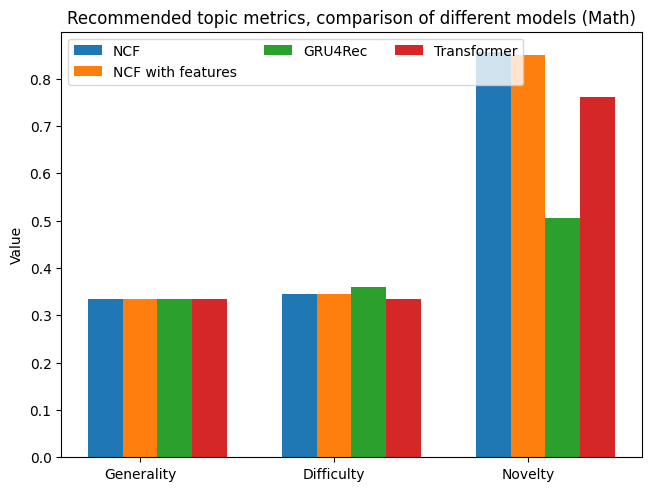

In [118]:
import matplotlib.pyplot as plt
import numpy as np






x = np.arange(len(metrics_labels))  # the label locations
width = 0.18  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Recommended topic metrics, comparison of different models (Math)')
ax.set_xticks(x + width, metrics_labels)
ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)

plt.show()

In [124]:
splitter = create_datasplitter(False, True, True, users, topics, documents, events, transactions)
german_feat_train_user_topics, german_feat_test_user_ids = collect_model_data_ncf("NCF with features", True, False, True, splitter)
splitter.change_features(False, None, None)
german_nofeat_train_user_topics, german_nofeat_test_user_ids = collect_model_data_ncf("NCF", True, False, False, splitter)

grusplit = collect_model_data_gru(False, True)


n = 5
 

L = 0
L_gru = 0


metrics = ['generality', 'difficulty', 'novelty']


func = {'generality': generality, 'difficulty': difficulty, 'novelty': novelty}

ncf = {'generality': 0, 'difficulty': 0, 'novelty': 0}
ncf_feature = {'generality': 0, 'difficulty': 0, 'novelty': 0}
gru4rec = {'generality': 0, 'difficulty': 0, 'novelty': 0}

transformer = compute_transformer_metrics(False, True)



for uid in RESULTS_GERMAN.keys():
    outputs = RESULTS_GERMAN[uid]

    for k in metrics:
        for i in range(len(outputs['NCF'])):
            ncf[k] += func[k](outputs['NCF'][i], uid, train_user_topics=german_nofeat_train_user_topics)
            ncf_feature[k] += func[k](outputs['NCF with features'][i], uid, train_user_topics=german_feat_train_user_topics)
            L += 1

L = L//3
for uid in GRU_GERMAN.keys():
 
    topics = GRU_GERMAN[uid]

    train_topics = grusplit.get_test_data()[uid][0]


    for t in topics:
        gru4rec['novelty'] += novelty_gru(t, train_topics)
        gru4rec['difficulty'] += difficulty(t, uid)
        gru4rec['generality'] += generality(t, uid)
        L_gru += 1



metrics_labels = ["Generality", "Difficulty", "Novelty"]
data = {
    'NCF': [ncf[k] for k in metrics],
    'NCF with features': [ncf_feature[k] for k in metrics],
}

for k in data.keys():
    for i in range(len(metrics)):
        data[k][i] /= L




for k in gru4rec.keys():
    gru4rec[k] /= L_gru
data["GRU4Rec"] = [gru4rec[k] for k in metrics]
data["Transformer"] = [transformer[k] for k in metrics]





x = np.arange(len(metrics_labels))  # the label locations
width = 0.18  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Recommended topic metrics, comparison of different models (Math)')
ax.set_xticks(x + width, metrics_labels)
ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)

plt.show()

tables loaded.


/home/david/ETH/recommender/data.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.apply(get_val, axis=1)


Sampled initial validation and test interactions
Completed test dataset
Completed validation dataset
Completed train dataset
Adding features...


/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type       | Params
-------------------------------------------------------
0 | student_embedding_layer | Embedding  | 4.4 M 
1 | topic_embedding_layer   | Embedding  | 4.4 K 
2 | user_embed_MLP          | Sequential | 278 K 
3 | user_feature_MLP        | Sequential | 82    
4 | topic_embed_MLP         | Sequential | 17.6 K
5 | topic_feature_MLP       | Sequential | 5     
6 | network                 | Sequential | 89.7 K
7 | loss                    | BCELoss 

intermediate layer size (concatenated): 325
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 152.30it/s]HitRate@10 0.4
NDCG@10 0.1351835267104859
MRR@10 0.06000000000000001
                                                                            

/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

Epoch 0: 100%|██████████| 1728/1728 [00:15<00:00, 113.90it/s, v_num=60, train_loss_step=0.605]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.7678571428571429
NDCG@10 0.43508902651263565
MRR@10 0.3326770925761609
Epoch 0: 100%|██████████| 1728/1728 [00:20<00:00, 85.27it/s, v_num=60, train_loss_step=0.605, val_loss=0.360, train_loss_epoch=0.450]

Metric val_loss improved. New best score: 0.360


Epoch 1: 100%|██████████| 1728/1728 [00:15<00:00, 113.60it/s, v_num=60, train_loss_step=0.438, val_loss=0.360, train_loss_epoch=0.450]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.7934782608695652
NDCG@10 0.4465870413585508
MRR@10 0.34074638913536426
Epoch 1: 100%|██████████| 1728/1728 [00:20<00:00, 84.18it/s, v_num=60, train_loss_step=0.438, val_loss=0.314, train_loss_epoch=0.404] 

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.314


Epoch 2: 100%|██████████| 1728/1728 [00:15<00:00, 112.06it/s, v_num=60, train_loss_step=0.569, val_loss=0.314, train_loss_epoch=0.404]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.8027950310559007
NDCG@10 0.4594630409822303
MRR@10 0.35372485950902094
Epoch 2: 100%|██████████| 1728/1728 [00:20<00:00, 83.59it/s, v_num=60, train_loss_step=0.569, val_loss=0.269, train_loss_epoch=0.373] 

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.269


Epoch 3: 100%|██████████| 1728/1728 [00:15<00:00, 111.88it/s, v_num=60, train_loss_step=0.304, val_loss=0.269, train_loss_epoch=0.373]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.8183229813664596
NDCG@10 0.48406889365211864
MRR@10 0.38055339889579015
Epoch 4: 100%|██████████| 1728/1728 [00:15<00:00, 111.78it/s, v_num=60, train_loss_step=0.465, val_loss=0.317, train_loss_epoch=0.350]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.8253105590062112
NDCG@10 0.48425446464190863
MRR@10 0.37872609188602974
Epoch 5: 100%|██████████| 1728/1728 [00:15<00:00, 111.85it/s, v_num=60, train_loss_step=0.333, val_loss=0.293, train_loss_epoch=0.330]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.8214285714285714
NDCG@10 0.49946002648127524
MRR@10 0.39994639160011836
Epoch 5: 100%|██████████| 1728/1728 [00:20<00:00, 83.33it/s, v_num=60, train_loss_step=0.333, val_loss=0.280, train_loss_epoch=0.310] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.269. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 1728/1728 [00:20<00:00, 83.00it/s, v_num=60, train_loss_step=0.333, val_loss=0.280, train_loss_epoch=0.310]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 3388/3388 [00:28<00:00, 118.13it/s]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


Testing DataLoader 0: 100%|██████████| 3388/3388 [00:30<00:00, 111.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       HitRate@10           0.8386080284970544
         MRR@10             0.42366208025887436
         NDCG@10            0.5216668103344458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
build train_user_topics
done
test user ids
done


/tmp/ipykernel_7934/612018477.py:69: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

intermediate layer size (concatenated): 320
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 159.56it/s]HitRate@10 0.8
NDCG@10 0.3527847991330242
MRR@10 0.215
                                                                            

/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

Epoch 0: 100%|██████████| 1728/1728 [00:15<00:00, 114.93it/s, v_num=61, train_loss_step=0.431]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.7725155279503105
NDCG@10 0.4380891534642725
MRR@10 0.3354699669722962
Epoch 0: 100%|██████████| 1728/1728 [00:20<00:00, 84.74it/s, v_num=61, train_loss_step=0.431, val_loss=0.312, train_loss_epoch=0.485]

Metric val_loss improved. New best score: 0.312


Epoch 1: 100%|██████████| 1728/1728 [00:15<00:00, 114.17it/s, v_num=61, train_loss_step=0.333, val_loss=0.312, train_loss_epoch=0.485]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.7849378881987578
NDCG@10 0.44479839561142837
MRR@10 0.34004023710933645
Epoch 2: 100%|██████████| 1728/1728 [00:14<00:00, 120.12it/s, v_num=61, train_loss_step=0.268, val_loss=0.333, train_loss_epoch=0.420]

/home/david/ETH/recommender/evaluation.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


HitRate@10 0.8020186335403726
NDCG@10 0.4557786239557261
MRR@10 0.34849804052055605
Epoch 2: 100%|██████████| 1728/1728 [00:19<00:00, 89.09it/s, v_num=61, train_loss_step=0.268, val_loss=0.296, train_loss_epoch=0.373] 

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.296


Epoch 3:  57%|█████▋    | 990/1728 [00:07<00:05, 123.99it/s, v_num=61, train_loss_step=0.270, val_loss=0.296, train_loss_epoch=0.373]

In [ ]:
# TODO: implement LIME-RS for the models, look at some specific test examples and compare

In [115]:
print("asdf")

asdf


In [119]:
data_splitter = SequentialSplitter(events_preprocessed_only_math)
BATCH_SIZE = 64
train_dataloader = DataLoader(data_splitter.get_train_dataset(), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(data_splitter.get_val_dataset(), batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(data_splitter.get_test_dataset(), batch_size=BATCH_SIZE, shuffle=False)

TOPIC_EMBEDDING_DIM = 64
HIDDEN_DIM = 256


gru4recmod = GRU4RecNetwork(
    num_topics=data_splitter.get_num_topics(),
    topic_embedding_dim=TOPIC_EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout_rate=0.3,
    loss=nn.NLLLoss(),
)


EPOCHS = 2

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=2,
    verbose=True,
    mode="min"
)

trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        accumulate_grad_batches=1,
        max_epochs=EPOCHS,
        callbacks=[TQDMProgressBar(refresh_rate=10), early_stop_callback],
        val_check_interval=0.5
)

trainer.fit(model=gru4recmod, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
trainer.test(model=gru4recmod, dataloaders=test_dataloader)

/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type       | Params
-----------------------------------------------------
0 | topic_embedding_layer | Embedding  | 2.8 K 
1 | dropout               | Dropout    | 0     
2 | gru_layer             | GRU        | 247 K 
3 | linear                | Linear     | 11.3 K
4 | activation            | LogSoftmax | 0     
5 | loss                  | NLLLoss    | 0     
-----------------------------------------------------
261 K     Trainable params
0         Non-trainable

/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  42%|████▏     | 30/71 [00:01<00:01, 23.38it/s, v_num=59, val_loss=2.720]

Metric val_loss improved. New best score: 2.723


Epoch 0:  99%|█████████▊| 70/71 [00:02<00:00, 28.36it/s, v_num=59, val_loss=2.490]

Metric val_loss improved by 0.235 >= min_delta = 0.0. New best score: 2.488


Epoch 1:  42%|████▏     | 30/71 [00:01<00:01, 27.13it/s, v_num=59, val_loss=2.430, train_loss=2.900]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 2.428


Epoch 1:  99%|█████████▊| 70/71 [00:02<00:00, 31.01it/s, v_num=59, val_loss=2.390, train_loss=2.900]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 2.387


Epoch 1: 100%|██████████| 71/71 [00:02<00:00, 31.22it/s, v_num=59, val_loss=2.390, train_loss=2.370]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 71/71 [00:02<00:00, 31.16it/s, v_num=59, val_loss=2.390, train_loss=2.370]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/david/anaconda3/envs/mlbd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 125.66it/s]


[{}]

In [121]:
gru4recmod.predict_proba

tensor([[0.0281, 0.0284, 0.0238,  ..., 0.0009, 0.0003, 0.0005],
        [0.0149, 0.0456, 0.0077,  ..., 0.0351, 0.0010, 0.0037],
        [0.0147, 0.0170, 0.0237,  ..., 0.0119, 0.0030, 0.0130],
        ...,
        [0.0295, 0.0264, 0.0186,  ..., 0.0268, 0.0038, 0.0200],
        [0.0034, 0.0115, 0.0039,  ..., 0.0206, 0.0004, 0.0020],
        [0.0456, 0.0175, 0.0248,  ..., 0.0092, 0.0096, 0.0165]])

In [ ]:
import torch
input = torch.tensor([[1,2,3,4,5]])

l = torch.tensor([[len(input)]], dtype=int)
gru4recmod(input, l, None)

In [55]:
data_splitter = SequentialSplitter(events_preprocessed_only_german)
BATCH_SIZE = 64

train_dataloader = DataLoader(data_splitter.get_train_dataset(), batch_size=1, shuffle=True)
val_dataloader = DataLoader(data_splitter.get_val_dataset(), batch_size=1, shuffle=False)
test_dataloader = DataLoader(data_splitter.get_test_dataset(), batch_size=1, shuffle=False)

In [56]:
for x in test_dataloader:
    print(x)
    break

[tensor([[ 0,  1,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  3,
          3,  3,  5,  6,  7,  5,  5,  5,  4,  4,  3,  4,  4,  2,  2,  3,  4,  4,
          1,  4,  2,  1,  8,  9, 10,  4,  4,  4,  2,  4, 11,  2,  0,  3,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0

In [62]:
sample = x 
x = x[0][0].detach().numpy()

In [74]:
x

array([ 0,  1,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        3,  3,  3,  5,  6,  7,  5,  5,  5,  4,  4,  3,  4,  4,  2,  2,  3,
        4,  4,  1,  4,  2,  1,  8,  9, 10,  4,  4,  4,  2,  4, 11,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [86]:
sample[1][0] = 49
sample[1]

tensor([49])

In [87]:
np.argmax(gru4recmod(torch.tensor([x]), sample[1], sample[2])[0].detach().numpy())

11

In [13]:
from predictions import get_predictions, write_outputs


predictions = get_predictions(data_splitter.get_test_data(), gru4rec.predict_proba, is_sequential=True, topic_ids=data_splitter.get_topic_ids())
predictions

[(0, 2065, 0, 0.06314189732074738),
 (0, 3250, 0, 0.005521687213331461),
 (0, 2055, 0, 0.05069487541913986),
 (0, 3119, 1, 0.2962069809436798),
 (0, 3, 0, 0.08755937218666077),
 (0, 3114, 0, 0.00995029415935278),
 (0, 3115, 0, 0.01268759835511446),
 (0, 3116, 0, 0.011353431269526482),
 (0, 3156, 0, 0.012709088623523712),
 (0, 3248, 0, 0.007003483362495899),
 (0, 3113, 0, 0.011902142316102982),
 (0, 2064, 0, 0.02208568900823593),
 (0, 3111, 0, 0.021726315841078758),
 (0, 3117, 0, 0.0003187581605743617),
 (0, 3319, 0, 0.037898775190114975),
 (0, 3320, 0, 0.04778675362467766),
 (0, 3110, 0, 0.032585639506578445),
 (0, 3163, 0, 0.046083007007837296),
 (0, 3323, 0, 0.031057432293891907),
 (0, 3154, 0, 0.007597425952553749),
 (0, 3112, 0, 0.02534373290836811),
 (0, 2023, 0, 0.036896828562021255),
 (0, 2042, 0, 0.004926788620650768),
 (0, 2048, 0, 0.0022983301896601915),
 (0, 3142, 0, 0.010178979486227036),
 (0, 3141, 0, 0.020801760256290436),
 (0, 3246, 0, 0.018802320584654808),
 (0, 3249, 0

In [14]:
df = pd.DataFrame(data=predictions, columns=["user_id", "topic_id", "-", "predict_proba"])
df


,user_id,topic_id,-,predict_proba
0,0,2065,0,0.063142
1,0,3250,0,0.005522
2,0,2055,0,0.050695
3,0,3119,1,0.296207
4,0,3,0,0.087559
...,...,...,...,...
259585,7634,3247,0,0.002944
259586,7634,3179,0,0.001719
259587,7634,3273,0,0.000231
259588,7634,3324,0,0.000007


In [16]:


user_predict = df.groupby(['user_id'])
for user, topic in user_predict:
    # Get the top N of highest probability and rank them 
    topN = [x for _, x in sorted(zip(topic['predict_proba'], topic['topic_id']), reverse=True)][:5]

    print(topN)
    break
    if math:
        res = GRU_MATH
    else:
        res = GRU_GERMAN

    

    res[user] = topN

[3119, 3, 2065, 2055, 3320]


/tmp/ipykernel_5981/3282205837.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


In [12]:
users = list(set(list(map(lambda x: x[0], predictions))))

In [17]:
data_splitter.get_test_data()[0]

([2065,
  3250,
  2055,
  3119,
  3119,
  3119,
  3119,
  3119,
  3119,
  3119,
  3119,
  3119,
  3119,
  3119,
  3119,
  3,
  3,
  3119,
  3119,
  3119,
  3114,
  3115,
  3116,
  3114,
  3114,
  3114,
  3,
  3,
  3119,
  3,
  3,
  2055,
  2055,
  3119,
  3,
  3,
  3250,
  3,
  2055,
  3250,
  3156,
  3248,
  3113,
  3,
  3,
  3,
  2055,
  3,
  2064,
  2055,
  2065,
  3119,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [100]:
recommender = TransformerRecommender(
    events_preprocessed_only_math,
    max_length=80,
    hidden_size=128,
    num_layers=2,
    num_heads=2,
    dropout=0.2
)

In [ ]:
recommender.train(
    batch_size=80,
    num_epochs=1,
    lr=0.001,
    window_size=2
)

In [102]:
train, test = recommender._split_sequences(recommender.sequences, 2)


In [108]:
recommender.sequences

{387604: array([1, 1, 2]),
 387605: array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,
         4,  4,  4,  4,  4,  4,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,
         7,  7,  7,  8,  9, 10, 11, 11, 11, 12, 13, 14, 15]),
 387608: array([ 3, 11, 11, 14, 16, 16, 17, 18, 18, 19, 20, 21, 21, 22, 23, 24, 24]),
 387650: array([ 2,  3,  3,  4,  5,  6,  9,  9,  9, 12, 12, 12, 12, 12, 12, 12, 12,
        13, 13, 14, 15, 18, 19, 19, 21, 21, 22, 22, 22, 22, 22, 23, 24, 24,
        25, 26, 26, 26, 27, 27, 27, 28, 28, 29, 29, 30, 30, 30, 31, 32, 32,
        33, 34]),
 387666: array([ 1,  1,  1,  6,  8,  8,  9,  9,  9, 11, 11, 11, 11, 14, 15, 15, 15,
        17, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24,
        26, 27, 27, 27, 27, 27, 28, 30, 31, 32, 34, 34, 35, 35, 35, 35, 35,
        36, 37]),
 387667: array([ 1,  1,  1,  1,  1,  6,  6,  6,  8,  8,  8,  8,  8,  8,  8,  9,  9,
         9,  9,  9,  9, 10, 10, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1

In [18]:
train = recommender._split_sequences(recommender.sequences, 2)[0]
s = set()
for x in train:
    s = s | set(x)
train_topics = list(map(lambda x: recommender.topic_decoder[x], list(s)))

{1, 2, 3}

In [20]:
recommender.topic_decoder[3]

956

In [99]:
recommender._split_sequences(recommender.sequences, 2)[1]

NameError: name 'recommender' is not defined